## 크롤링으로 웹 데이터 가져오기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import re

# 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
window_path = "chromedriver.exe"

# 크롤링할 사이트 주소를 입력
source_url = "https://news.naver.com/main/main.naver?mode=LSD&mid=shm&sid1=100"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
service = Service(executable_path=window_path)
driver = webdriver.Chrome(service=service)  
driver.get(source_url)
req = driver.page_source
soup = BeautifulSoup(req, "html.parser")
cluster_text = soup.find_all(name="div", attrs={"class":"sa_text"})

# a태그의 href를 리스트로 추출하여 크롤링 할 페이지 리스트를 생성
page_urls = []
for index in range(0, len(cluster_text)):
    cluster = cluster_text[index]
    news_url = cluster.find(name="a", attrs={"class":"sa_text_title"})
    if news_url is not None:
        page_urls.append(news_url.get("href"))

# 중복 url을 제거
page_urls = list(set(page_urls))

for page in page_urls[:5]:
    print(page)

driver.close()

https://n.news.naver.com/mnews/article/002/0002333882
https://n.news.naver.com/mnews/article/056/0011731214
https://n.news.naver.com/mnews/article/421/0007570717
https://n.news.naver.com/mnews/article/032/0003299277
https://n.news.naver.com/mnews/article/055/0001159290


### 페이지내 텍스트 구조 확인

In [3]:
service = Service(executable_path=window_path)
driver = webdriver.Chrome(service=service)  
driver.get(page_urls[0])
req = driver.page_source
soup = BeautifulSoup(req, 'html.parser')
title_area = soup.find(name='div', attrs={'class': 'media_end_head_title'})
title = title_area.find_all('h2')[0]
content_paragraphs = soup.find(name='div', attrs={'class':'newsct_article'})
content_corpus = content_paragraphs.text

print(title.text)
print("\n")
print(content_corpus)

driver.close()

눈에는 눈 이에는 이? 전단 날린 김여정 "표현의 자유, 대한민국 양해하길"




북한 전단 살포 경보문자 보낸 남한에 "저들이 늘쌍 하던 일을 좀 해보았는데 왜 야단 떠는지""조선민주주의인민공화국(북한) 정부는 대한민국에 대한 삐라살포가 우리 인민의 표현의 자유에 해당되며 한국 국민들의 알 권리를 보장하는 것으로서 이를 당장 제지시키는 데는 한계점이 있다. 대한민국 정부에 정중히 량해(양해)를 구하는 바이다" 29일 북한이 남한을 상대로 전단 및 쓰레기가 담긴 풍선을 날려 보낸 가운데, 김여정 북한 당 중앙위원회 부부장은 본인 명의의 담화를 통해 그간 남한의 민간단체가 보낸 대북전단과 마찬가지로 자신들도 비슷한 행위를 한 것이라며 이같이 밝혔다. 김 부부장은 "한국 괴뢰군대 합동참모본부는 어제(28일) 밤부터 우리가 다량의 풍선을 대한민국에 살포하고 있다고 하면서 이러한 행위는 국제법을 명백히 위반한 것이고 자국민의 안전을 심각하게 위협하는 행위이며 반인륜적이고 저급한 행위라고 하면서 즉각 중단하라고 고아댔다"며 "우리가 저들이 늘쌍 하던 일을 좀 해보았는데 왜 불소나기를 맞은 것처럼 야단을 떠는지 모를 일"이라고 말했다. 그는 남한의 이러한 반응에 대해 "우리가 수 년 동안 그리도 문제시하며 중단을 요구해왔던 너절한 물건살포놀음에 저들자신이 직접 당해보고 나서야 결국 단 하루 만에 백기를 들고 투항한 셈"이라고 꼬집었다. 김 부부장은 "저 한국것들의 눈깔에는 북으로 날아가는 풍선은 안보이고 남으로 날아오는 풍선만 보였을가?"라며 "지금 쓰레기같은 한국 것들은 우리에 대한 저들의 전단살포는 '표현의 자유'라고 떠들고 그에 상응한 꼭 같은 우리의 행동에 대해서는 '국제법의 명백한 위반'이라는 뻔뻔스러운 주장을 펴고있는 것"이라며 한국 정부가 이중 잣대를 들이대고 있다고 주장했다. 그는 "풍선이 날아가는 방향에 따라서 '표현의 자유'와 '국제법'이 규정되는가? 뻔뻔스러움의 극치"라며 "한국 족속들이라는 것이 얼마나 졸렬하고 철면피한 것들인가를 다시금 확인할 수

### 뉴스 헤드라인 데이터 크롤링

In [4]:
# 크롤링한 데이터를 df로 만들기 위한 작업
columns = ['title', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '본문' 데이터를 데이터 프레임으로 만들기
for page_url in page_urls:
    service = Service(executable_path=window_path)
    driver = webdriver.Chrome(service=service)
    driver.get(page_url)
    req = driver.page_source
    soup = BeautifulSoup(req, 'html.parser')

    title_area = soup.find(name="div", attrs={"class":"media_end_head_title"})
    title = title_area.find_all('h2')[0] if title_area else None
    content_paragraphs = soup.find(name="div", attrs={"class":"newsct_article"})
    content_corpus = content_paragraphs.text if content_paragraphs else ""

    # '제목' 데이터에서 개행 문자 제거
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""

    # 모든 데이터를 하나의 데이터 프레임에 저장
    row = [row_title, content_corpus]
    series = pd.Series(row, index=df.columns)
    df = pd.concat([df, pd.DataFrame([series])], ignore_index=True)

    driver.close()

In [5]:
df.head(3)

,title,content_text
0,"눈에는 눈 이에는 이? 전단 날린 김여정 ""표현의 자유, 대한민국 양해하길""","\n\n북한 전단 살포 경보문자 보낸 남한에 ""저들이 늘쌍 하던 일을 좀 해보았는데..."
1,왜 이 시기에 ‘오물 풍선’ 살포?…김여정 “표현의 자유” 비아냥,"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n[앵커] 그렇다면, 북한..."
2,"'민주당의 입' 한민수, 민심 대변인으로…""최우선 과제는 채해병 특검법""","\n\n[여의도 신인]㉓ 강북을 한민수 ""국민 이기는 정부 없다…거부권 그만""""늦은..."


## 키워드 정보 추출하기
- 전처리 필요
- re 모듈을 통해 정규표현식을 사용할 수 있다

In [6]:
# 한글 이외의 문자는 제거하는 함수
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식
    result = hangul.sub('',text)
    return result

print(text_cleaning(df['content_text'][0]))

북한 전단 살포 경보문자 보낸 남한에 저들이 늘쌍 하던 일을 좀 해보았는데 왜 야단 떠는지조선민주주의인민공화국북한 정부는 대한민국에 대한 삐라살포가 우리 인민의 표현의 자유에 해당되며 한국 국민들의 알 권리를 보장하는 것으로서 이를 당장 제지시키는 데는 한계점이 있다 대한민국 정부에 정중히 량해양해를 구하는 바이다 일 북한이 남한을 상대로 전단 및 쓰레기가 담긴 풍선을 날려 보낸 가운데 김여정 북한 당 중앙위원회 부부장은 본인 명의의 담화를 통해 그간 남한의 민간단체가 보낸 대북전단과 마찬가지로 자신들도 비슷한 행위를 한 것이라며 이같이 밝혔다 김 부부장은 한국 괴뢰군대 합동참모본부는 어제일 밤부터 우리가 다량의 풍선을 대한민국에 살포하고 있다고 하면서 이러한 행위는 국제법을 명백히 위반한 것이고 자국민의 안전을 심각하게 위협하는 행위이며 반인륜적이고 저급한 행위라고 하면서 즉각 중단하라고 고아댔다며 우리가 저들이 늘쌍 하던 일을 좀 해보았는데 왜 불소나기를 맞은 것처럼 야단을 떠는지 모를 일이라고 말했다 그는 남한의 이러한 반응에 대해 우리가 수 년 동안 그리도 문제시하며 중단을 요구해왔던 너절한 물건살포놀음에 저들자신이 직접 당해보고 나서야 결국 단 하루 만에 백기를 들고 투항한 셈이라고 꼬집었다 김 부부장은 저 한국것들의 눈깔에는 북으로 날아가는 풍선은 안보이고 남으로 날아오는 풍선만 보였을가라며 지금 쓰레기같은 한국 것들은 우리에 대한 저들의 전단살포는 표현의 자유라고 떠들고 그에 상응한 꼭 같은 우리의 행동에 대해서는 국제법의 명백한 위반이라는 뻔뻔스러운 주장을 펴고있는 것이라며 한국 정부가 이중 잣대를 들이대고 있다고 주장했다 그는 풍선이 날아가는 방향에 따라서 표현의 자유와 국제법이 규정되는가 뻔뻔스러움의 극치라며 한국 족속들이라는 것이 얼마나 졸렬하고 철면피한 것들인가를 다시금 확인할 수 있는 기회라고 지적했다 김 부부장은 전체 조선인민이 신성시하는 우리의 사상과 제도를 헐뜯는 정치선동오물인 삐라장들과 시궁창에서 돋아난 저들의 잡사상을 우리에게 

In [7]:
# 모든 데이터에 적용하기
df['title'] = df['title'].apply(lambda x:text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x:text_cleaning(x))
df.head()

,title,content_text
0,눈에는 눈 이에는 이 전단 날린 김여정 표현의 자유 대한민국 양해하길,북한 전단 살포 경보문자 보낸 남한에 저들이 늘쌍 하던 일을 좀 해보았는데 왜 야단...
1,왜 이 시기에 오물 풍선 살포김여정 표현의 자유 비아냥,앵커 그렇다면 북한이 이 시기에 갑자기 오물까지 넣은 풍선 살포에 나선 의도는 무...
2,민주당의 입 한민수 민심 대변인으로최우선 과제는 채해병 특검법,여의도 신인 강북을 한민수 국민 이기는 정부 없다거부권 그만늦은 만큼 간절했고 과분...
3,단독 외교부 일본 개황에서 역사 왜곡 발언 사례 통째로 삭제,년 월 발간한 일본 개황 자료과거사 반성 발언역사교과서 문제도 빠져객관적 사실조차 ...
4,통화 놓고 여야 공방스모킹 건논점 벗어나,앵커채 해병 사망 사건을 조사한 해병대 수사단이 사건 기록을 경찰에 넘기던 날 윤석...


#### 키워드 분석을 위한 말뭉치 만들기

In [8]:
title_corpus = "".join(df['title'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

눈에는 눈 이에는 이 전단 날린 김여정 표현의 자유 대한민국 양해하길왜 이 시기에 오물 풍선 살포김여정 표현의 자유 비아냥민주당의 입 한민수 민심 대변인으로최우선 과제는 채해병 특검법단독 외교부 일본 개황에서 역사 왜곡 발언 사례 통째로 삭제통화 놓고 여야 공방스모킹 건논점 벗어나대 샛별이주영 의사는 공급자이자 소비자거위 배 가르지 않는다어제는 눈물의 가수 리아 오늘은 열정 국회의원 김재원 이일내일차기 주자  마의 벽 넘은 이준석 부끄럽다어리석은 사람  맞다슈퍼초선 이준석의 미래는대선 앞두고 킹메이커 의 길로터치다운은 좌클릭 필승개그맨 김영민 정부 버닝썬 경찰총장 윤규근 저격민주 의장단 후보원내대표 선출에 권리당원 투표  반영오물풍선 살포에  교란 의도는시작부터 꼬인 대 국회 최악 오명대는 더 할 것 섬뜩한 경고중담 대통령님 계란말이 말고 제대로 된 설명이 필요합니다세 불리는 이재명 친위대 혁신회의강성 당원의 정국 주도 현실화김여정 성의의 선물계속 주워 담아야 할 것대 국회 범야 석 압도적 여소야대대 명 초선 명윤 대통령 전세사기특별법 등 개 거부민주 다시 발의속보 한 억불 운반선 건조 의향서 등 개 협정 체결명 에 필요한  이탈표 줄어도채상병 특검 어려운 이유대 국회 마지막 날 윤 대통령 번째 거부권 행사민생 포기나경원 한동훈 소중한 대권후보조국 현행 교섭단체 구성 요건은 유신의 잔재 투데이 여의도 스케치불법자금 폐단으로 사라진 지구당이재명한동훈 부활론마지막날까지 네탓하며 문닫는 대 국회단독 방사청 중국산 의혹 알고도 검증 소홀전력 공백 우려대 국회 개원특검법원구성 등 시작부터 대치 정국북한 새벽부터 탄도미사일 여발 쐈다정찰위성 폭발 사흘만연합뉴스 이 시각 헤드라인  월일 시작되는 국회의원 임기 여의도가 왜 그럴까서용주  이종섭에 번 전화 누군가 강력한 민원 넣은 듯한판승부우상호 맛 간  막말 양문석에 선거 도와달랄 땐 형님 하더니국민연금 민생지원금 차등 지급이재명 여 상대 민생 정치 가속 멍청하다 평가한 이준석 지적받자 그럼 싸가지 없다는진수희 장관시절 대

In [9]:
!pip install konlpy

In [10]:
!pip install jpype1

In [11]:
!pip install Jpype1-py3

In [12]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [13]:
count

Counter({'것': 314,
         '국회': 233,
         '일': 208,
         '대통령': 205,
         '이': 177,
         '민주당': 157,
         '수': 149,
         '의원': 139,
         '국민': 136,
         '년': 119,
         '대표': 117,
         '등': 116,
         '말': 104,
         '법안': 100,
         '전': 98,
         '북한': 90,
         '수사': 83,
         '대해': 80,
         '우리': 78,
         '그': 77,
         '힘': 76,
         '월': 74,
         '때': 71,
         '정치': 69,
         '제': 68,
         '저': 66,
         '정부': 63,
         '문제': 60,
         '특검법': 60,
         '미사일': 60,
         '서울': 59,
         '발사': 58,
         '위': 58,
         '윤': 58,
         '표': 58,
         '생각': 57,
         '안': 56,
         '뉴스': 56,
         '지난': 55,
         '처': 55,
         '혁신': 55,
         '관련': 54,
         '거부권': 54,
         '민생': 54,
         '거': 54,
         '분': 54,
         '당원': 53,
         '게': 53,
         '장관': 52,
         '기자': 52,
         '당선인': 52,
         '재': 52,
         '행사': 

## 불용어 제거

In [14]:
# 한국어 약식 불용어사전 예시 파일
korean_stopwords_path = "../python-data-analysis/data/korean_stopwords.txt"

with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [15]:
naver_news_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in naver_news_stopwords:
    stopwords.append(stopword)

In [16]:
count = Counter({x : count[x] for x in count if x not in stopwords})
print(count)

Counter({'국회': 233, '대통령': 205, '민주당': 157, '수': 149, '의원': 139, '국민': 136, '대표': 117, '말': 104, '법안': 100, '전': 98, '북한': 90, '수사': 83, '대해': 80, '힘': 76, '정치': 69, '정부': 63, '문제': 60, '특검법': 60, '미사일': 60, '서울': 59, '발사': 58, '위': 58, '윤': 58, '표': 58, '안': 56, '뉴스': 56, '지난': 55, '처': 55, '혁신': 55, '관련': 54, '거부권': 54, '민생': 54, '거': 54, '분': 54, '당원': 53, '게': 53, '장관': 52, '기자': 52, '당선인': 52, '재': 52, '행사': 52, '대한': 49, '특검': 49, '개혁': 48, '국회의원': 47, '사건': 47, '통화': 46, '사람': 46, '명': 46, '지원': 46, '더': 45, '여당': 45, '총선': 45, '조국': 43, '지금': 42, '위원장': 42, '윤석열': 42, '이재명': 42, '주장': 41, '임기': 41, '라며': 40, '건': 40, '날': 40, '채': 38, '야권': 38, '일본': 38, '석': 38, '법': 37, '처리': 37, '이탈': 37, '채상병': 37, '평가': 36, '얘기': 36, '중': 35, '회의': 35, '살포': 33, '대통령실': 33, '부분': 33, '한국': 32, '당': 32, '시': 32, '최고': 32, '정당': 32, '후': 31, '시작': 31, '박재홍': 31, '함': 31, '위해': 30, '당시': 30, '여의도': 30, '야당': 30, '위원': 29, '해병대': 29, '전화': 28, '본회의': 28, '개': 28, '원내대표': 28, '입장': 27, '통과': 27

In [17]:
# 한글자 키워드를 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'국회': 233, '대통령': 205, '민주당': 157, '의원': 139, '국민': 136, '대표': 117, '법안': 100, '북한': 90, '수사': 83, '대해': 80, '정치': 69, '정부': 63, '문제': 60, '특검법': 60, '미사일': 60, '서울': 59, '발사': 58, '뉴스': 56, '지난': 55, '혁신': 55, '관련': 54, '거부권': 54, '민생': 54, '당원': 53, '장관': 52, '기자': 52, '당선인': 52, '행사': 52, '대한': 49, '특검': 49, '개혁': 48, '국회의원': 47, '사건': 47, '통화': 46, '사람': 46, '지원': 46, '여당': 45, '총선': 45, '조국': 43, '지금': 42, '위원장': 42, '윤석열': 42, '이재명': 42, '주장': 41, '임기': 41, '라며': 40, '야권': 38, '일본': 38, '처리': 37, '이탈': 37, '채상병': 37, '평가': 36, '얘기': 36, '회의': 35, '살포': 33, '대통령실': 33, '부분': 33, '한국': 32, '최고': 32, '정당': 32, '시작': 31, '박재홍': 31, '위해': 30, '당시': 30, '여의도': 30, '야당': 30, '위원': 29, '해병대': 29, '전화': 28, '본회의': 28, '원내대표': 28, '입장': 27, '통과': 27, '헌법': 27, '차례': 27, '개원': 27, '원금': 27, '여야': 27, '협력': 27, '이종섭': 27, '중심': 27, '전단': 26, '위원회': 26, '통해': 26, '계속': 26, '기록': 26, '선거': 26, '의혹': 25, '요구': 24, '비판': 24, '제안': 24, '구성': 24, '검찰': 24, '박상수': 24, '서용주': 24, '국가': 23, 

## 시각화

In [18]:
!pip install pytagcloud pygame simplejson

In [19]:
!where python

C:\Users\shash\anaconda3\python.exe
C:\Users\shash\AppData\Local\Microsoft\WindowsApps\python.exe


In [20]:
import random
import pytagcloud
import webbrowser

ranked_tags = count.most_common(40)

taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


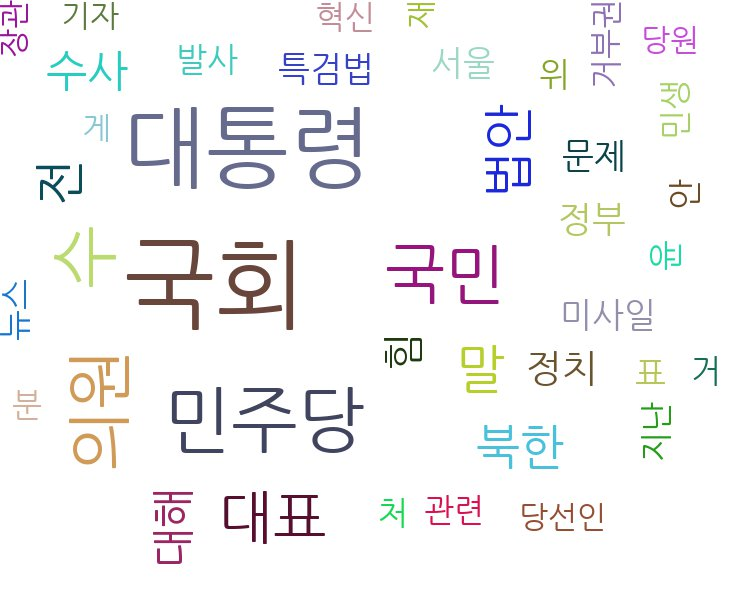

In [22]:
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(800, 600), fontname='NanumGothic', rectangular=False)

from IPython.display import Image
Image(filename='wordcloud.jpg')